In [1]:
#load the local data
from google.colab import files
uploaded = files.upload()

Saving GlobalLandTemperaturesByCountry.csv to GlobalLandTemperaturesByCountry.csv



Analysis for India
----------------------------------------


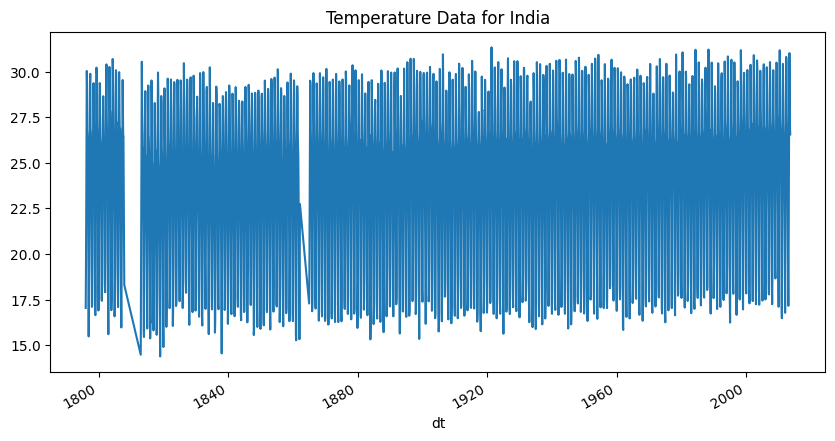

ADF Statistic for India Original Data: -4.5585
p-value for India Original Data: 0.0002


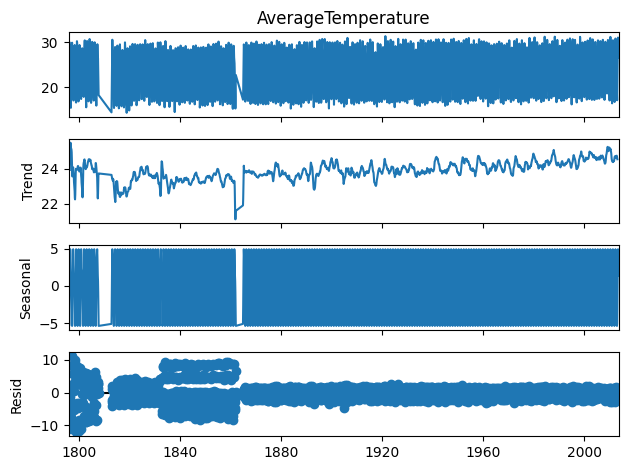

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


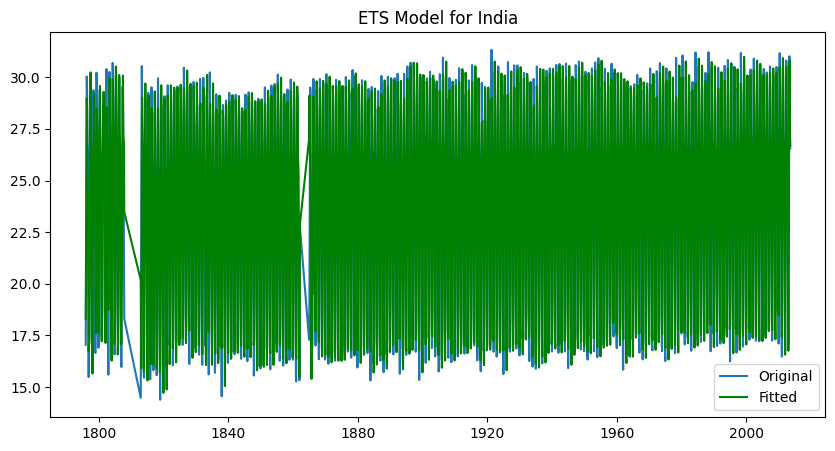

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3178.92
Distribution:                  Normal   AIC:                           6365.85
Method:            Maximum Likelihood   BIC:                           6389.16
                                        No. Observations:                 2508
Date:                Wed, Nov 27 2024   Df Residuals:                     2507
Time:                        15:17:19   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu             0.0163  1.906e-02      0.853      0.394 

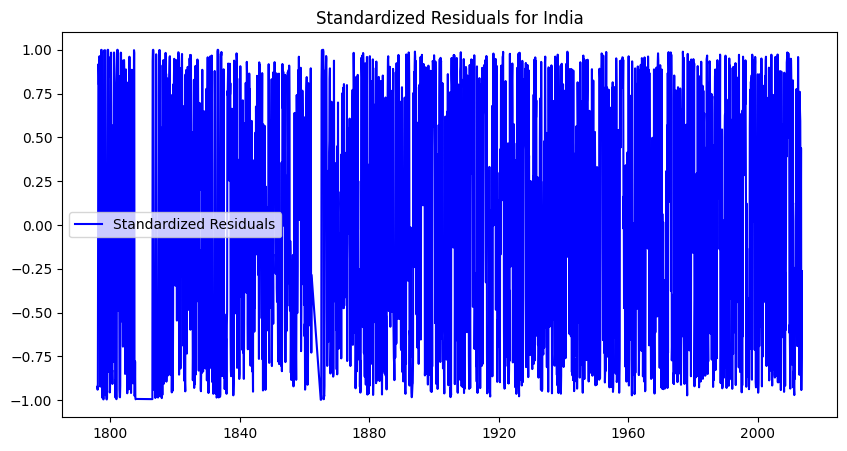

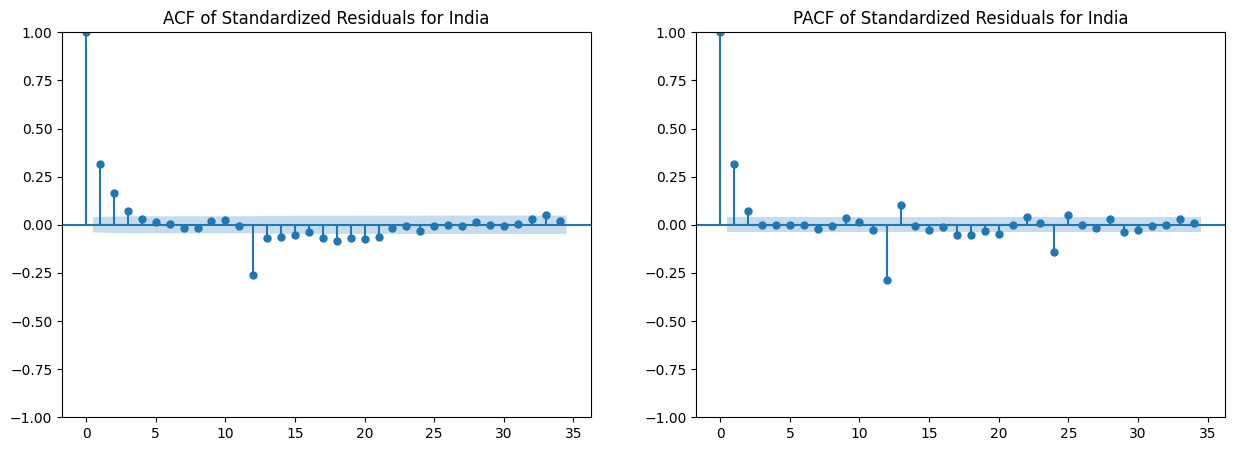

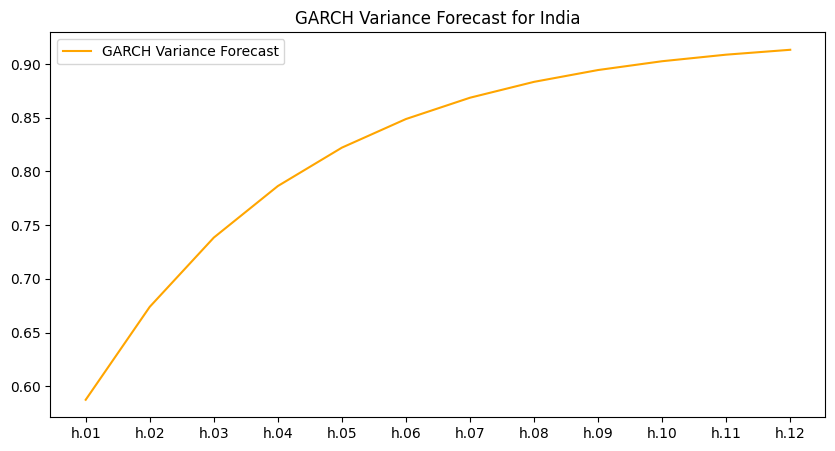

In [4]:
!pip install arch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import scipy.stats as stats
import statsmodels.api as sm

# Load dataset
file_path = 'GlobalLandTemperaturesByCountry.csv'
data = pd.read_csv(file_path)

# Preprocess data
data['dt'] = pd.to_datetime(data['dt'])
data.set_index('dt', inplace=True)

# List of cities to analyze
cities = ['India']

# Function to perform ADF test
def adf_test(series, title=''):
    result = adfuller(series.dropna(), autolag='AIC')
    print(f'ADF Statistic for {title}: {result[0]:.4f}')
    print(f'p-value for {title}: {result[1]:.4f}')
    return result[1] <= 0.05

# Analysis function for each city
def analyze_city(city):
    print(f"\nAnalysis for {city}\n{'-'*40}")

    # Filter city data
    city_data = data[data['Country'] == city]['AverageTemperature']

    # Drop NA values
    city_data = city_data.dropna()

    # Plot data
    city_data.plot(title=f"Temperature Data for {city}", figsize=(10, 5))
    plt.show()

    # Check for stationarity
    stationary = adf_test(city_data, title=f"{city} Original Data")
    if not stationary:
        diff_data = city_data.diff().dropna()
        stationary = adf_test(diff_data, title=f"{city} Differenced Data")
    else:
        diff_data = city_data

    # Decompose time series
    decomposition = seasonal_decompose(city_data, model='additive', period=12)
    decomposition.plot()
    plt.show()

    # Fit ETS model
    ets_model = ExponentialSmoothing(city_data, seasonal='add', seasonal_periods=12).fit()

    plt.figure(figsize=(10, 5))
    plt.plot(city_data, label='Original')
    plt.plot(ets_model.fittedvalues, label='Fitted', color='green')
    plt.title(f"ETS Model for {city}")
    plt.legend()
    plt.show()

        # GARCH model
    residuals = ets_model.resid
    garch_model = arch_model(residuals.dropna(), vol='Garch', p=1, q=1)
    garch_fit = garch_model.fit(disp="off")
    print(garch_fit.summary())

    # Standardize the residuals using GARCH
    garch_conditional_std = np.sqrt(garch_fit.resid**2 + garch_fit.params['omega'])
    standardized_residuals = residuals.dropna() / garch_conditional_std

    # Residual Analysis
    print(f"\nResidual Analysis for {city}\n{'-'*40}")
    plt.figure(figsize=(10, 5))
    plt.plot(standardized_residuals, label='Standardized Residuals', color='blue')
    plt.title(f"Standardized Residuals for {city}")
    plt.legend()
    plt.show()

    # ACF and PACF Plots
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    plot_acf(standardized_residuals, ax=axes[0], title=f"ACF of Standardized Residuals for {city}")
    plot_pacf(standardized_residuals, ax=axes[1], title=f"PACF of Standardized Residuals for {city}")
    plt.show()



    # GARCH Variance Forecast
    garch_forecast = garch_fit.forecast(horizon=12)
    plt.figure(figsize=(10, 5))
    plt.plot(garch_forecast.variance.iloc[-1], label='GARCH Variance Forecast', color='orange')
    plt.title(f"GARCH Variance Forecast for {city}")
    plt.legend()
    plt.show()



# Run analysis for each city
for city in cities:
    analyze_city(city)